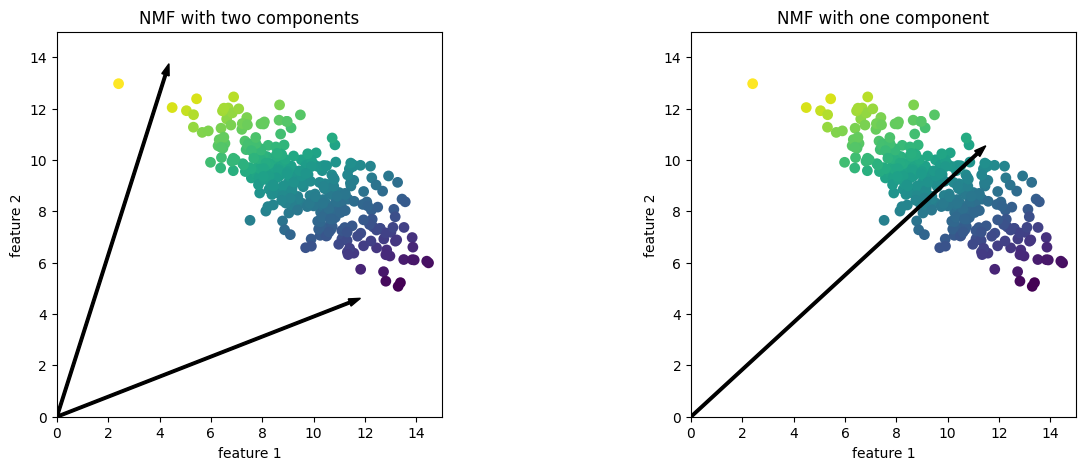

In [28]:
%matplotlib inline
# Le principe de PCA est de trouver les composantes principales orthogonales qui maximisent la variance
# Le principe des matrices de factorisation non négatives est de trouver de décomposer une classe en une somme
# de composantes non négatives


from joblib import Memory

try:
    memory = Memory(cachedir="cache")
except TypeError:
    # joblib.Memory changed its API in 0.12
    memory = Memory(location="cache", verbose=0)
    
    
# pour le jeu de données jouet

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

def plot_nmf_illustration():
    rnd = np.random.RandomState(4)
    X_ = rnd.normal(size=(300, 2))
    # Add 8 to make sure every point lies in the positive part of the space
    X_blob = np.dot(X_, rnd.normal(size=(2, 2))) + rnd.normal(size=2) + 8

    nmf = NMF(random_state=0,solver='cd')
    nmf.fit(X_blob)
    X_nmf = nmf.transform(X_blob)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(X_blob[:, 0], X_blob[:, 1], c=X_nmf[:, 0], linewidths=0,
                    s=60, cmap='viridis')
    axes[0].set_xlabel("feature 1")
    axes[0].set_ylabel("feature 2")
    axes[0].set_xlim(0, 15)
    axes[0].set_ylim(0, 15)
    axes[0].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
                  head_width=.3, color='k')
    axes[0].arrow(0, 0, nmf.components_[1, 0], nmf.components_[1, 1], width=.1,
                  head_width=.3, color='k')
    axes[0].set_aspect('equal')
    axes[0].set_title("NMF with two components")

    # second plot
    nmf = NMF(random_state=0, n_components=1, solver='mu')
    nmf.fit(X_blob)

    axes[1].scatter(X_blob[:, 0], X_blob[:, 1], c=X_nmf[:, 0], linewidths=0,
                    s=60, cmap='viridis')
    axes[1].set_xlabel("feature 1")
    axes[1].set_ylabel("feature 2")
    axes[1].set_xlim(0, 15)
    axes[1].set_ylim(0, 15)
    axes[1].arrow(0, 0, nmf.components_[0, 0], nmf.components_[0, 1], width=.1,
                  head_width=.3, color='k')

    axes[1].set_aspect('equal')
    axes[1].set_title("NMF with one component")
    
plot_nmf_illustration()

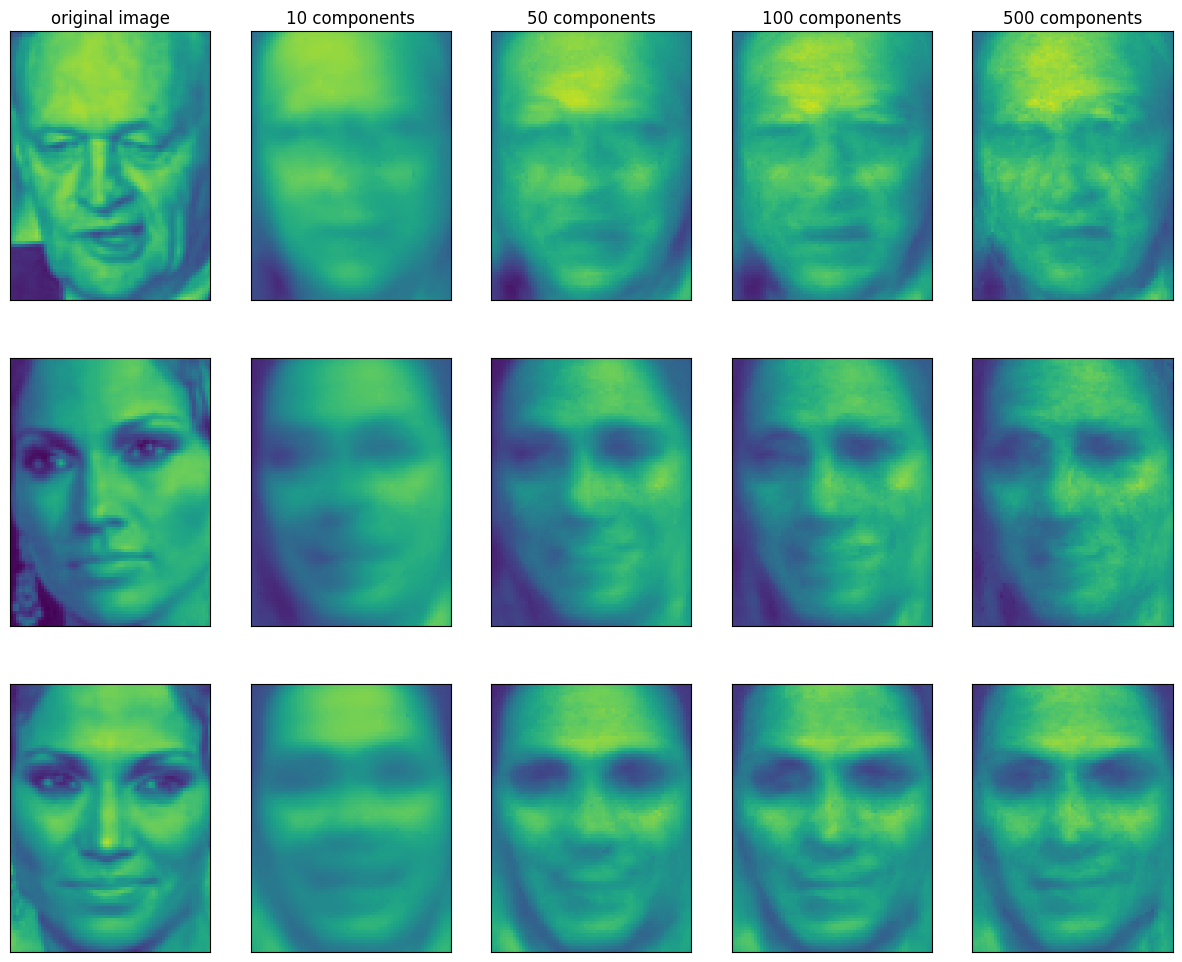

In [33]:
# Illustration de la reconstruction des données avec NMF
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import mglearn

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
mask = np.zeros(people.target.shape, dtype=np.bool_)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1 

X_people = people.data[mask]
y_people = people.target[mask]

X_train,X_test,y_train,y_test = train_test_split(X_people,y_people,stratify=y_people,random_state=0)
image_shape = people.images[0].shape

@memory.cache
def nmf_faces(X_train, X_test):
    # Build NMF models with 10, 50, 100 and 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        nmf = NMF(n_components=n_components, random_state=0, solver='mu',max_iter=300)
        nmf.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_nmf = nmf.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = np.dot(X_test_nmf, nmf.components_)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_nmf_faces(X_train, X_test, image_shape):
    reduced_images = nmf_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("original image")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d components" % n_components)
        
plot_nmf_faces(X_train,X_test,image_shape)

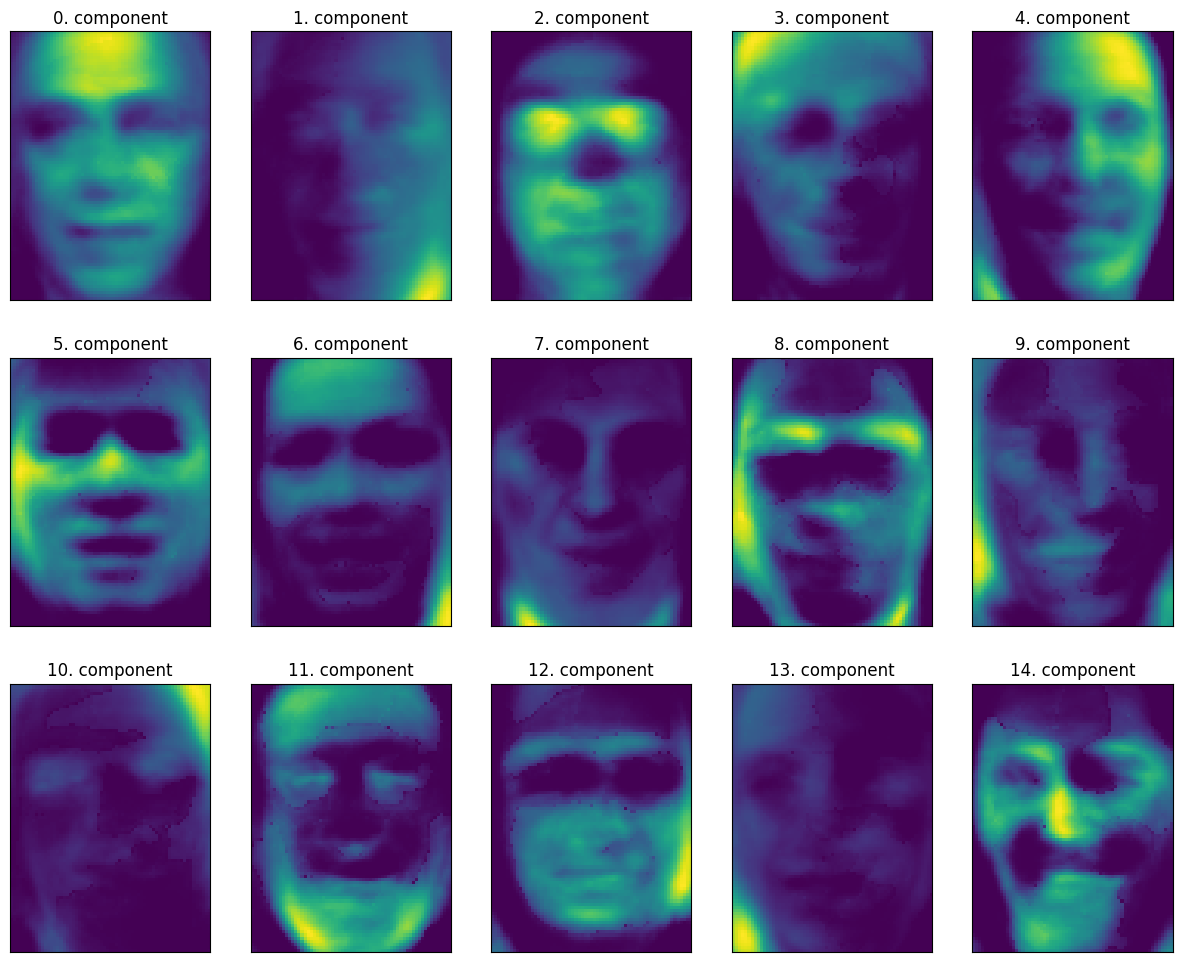

In [34]:
# Le reconstruction est moins bonne qualité qu'avec les composantes principales puisque pca trouve les
# directions optimales en termes de reconstruction.
nmf = NMF(n_components=15, random_state=0, max_iter=300, solver='mu')
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3,5, figsize=(15,12), subplot_kw={'xticks':(),'yticks':()})
for i, (component,ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))
    
# Avec l'apprentissage NMF, on cherche des motifs intéressant   

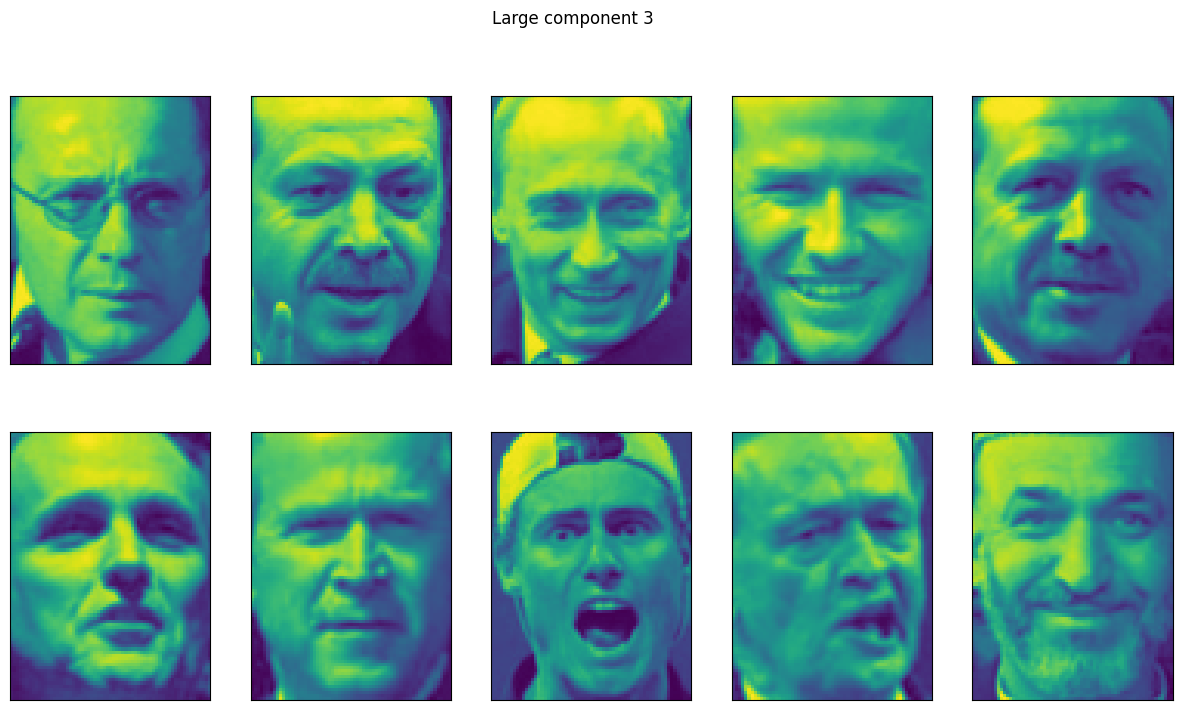

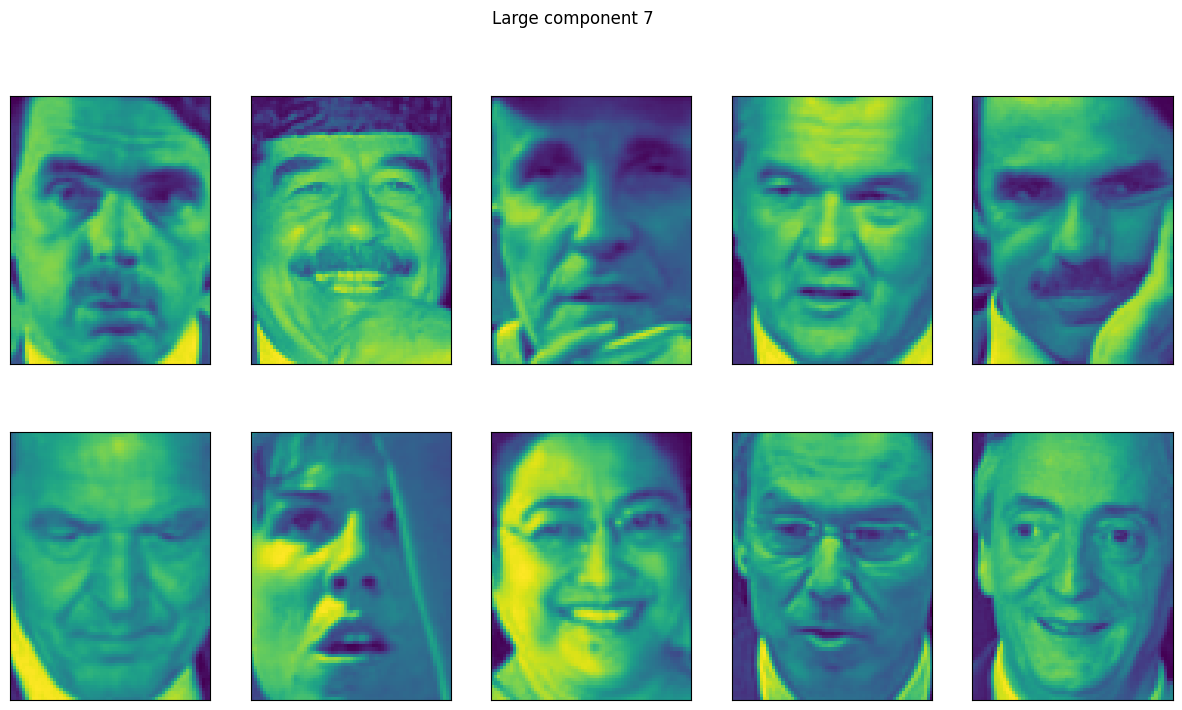

In [40]:
# Par exemple, on peut cherche les corrélations entre un visage et une des composantes définies par NMF

def draw_correlation(compn):
    inds = np.argsort(X_train_nmf[:,compn])[::-1]
    fig,axes = plt.subplots(2,5,figsize=(15,8), subplot_kw={'xticks':(),'yticks':()})
    fig.suptitle("Large component {}".format(compn))
    for i, (ind,ax) in enumerate(zip(inds,axes.ravel())):
        ax.imshow(X_train[ind].reshape(image_shape))

draw_correlation(3)
draw_correlation(7)

Text(0, 0.5, 'Signal')

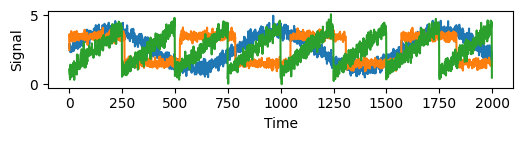

In [42]:
# Les signaux comportant une structure additive sont propices à l'extraction de composantes à forte signification
# sémantique ( les signaux audio par exemple )
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6,1))
plt.plot(S,'-')
plt.xlabel('Time')
plt.ylabel('Signal')

# On se donne le signal original suivant

In [45]:
# Mais nous n'avons pas le loisir d'avoir les sources du signal, seulement des dispositifs nous fournissant
# des échantillons
A = np.random.RandomState(0).uniform(size=(100,3))
X = np.dot(S, A.T)
print("Forme : {}".format(X.shape))

Forme : (2000, 100)


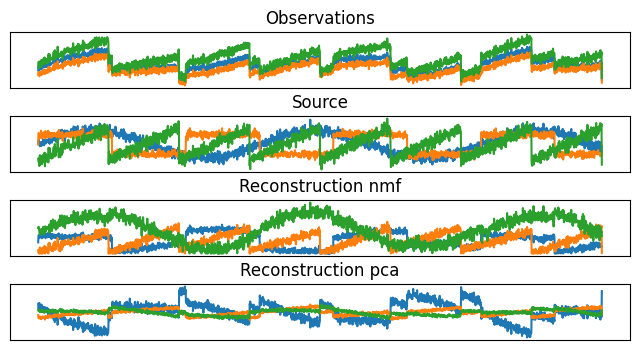

In [46]:
# On peut utiliser nmf pour retrouver les 3 signaux (qui sont les corrélations parfaites)
nmf = NMF(n_components=3,random_state=42)
S_ = nmf.fit_transform(X)

# à titre de comparaison, utilisons PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)

models = [X,S,S_,H]
names = ['Observations','Source','Reconstruction nmf','Reconstruction pca']
fig,axes = plt.subplots(4,figsize=(8,4),gridspec_kw={'hspace': .5}, subplot_kw={'xticks':(),'yticks':()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3],'-')